In [3]:
import os
import csv
import copy
import pandas as pd
from statistics import median, mean
import numpy as np
import scipy.stats as st
from sentiment import calc_accuracy
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image
from lang_codes import lang_codes

# Reading Data
Reads the output files of bootstrap.py and saves it to a dictionary `data`. Edit the directory name passed to the read functions if your directory names differ.

### Sentiment Analysis Task

In [2]:
def read_sentiment_data(dir_name: str):
    data = {
        "Pipeline 1": {},
        "Pipeline 2": {},
        "Pipeline 3": {},
    }

    # Go through each pipeline
    for pline in sorted(os.listdir(dir_name)):
        if pline == "Tweet text_Clean_Label":
            pipeline = "Pipeline 1"
        elif pline == "TranslatedToEnglish_Label":
            pipeline = "Pipeline 2"
        else:
            pipeline = "Pipeline 3"

        pipeline_dir_name = dir_name + "/" + pline

        # Go through each subset (with and without neutrals)
        for subset in sorted(os.listdir(pipeline_dir_name)):  # subset is AllTweets or NoNeuTweets
            data[pipeline][subset] = {}

            subset_dir_name = pipeline_dir_name + "/" + subset

            # Go through each language
            for lang_file in sorted(os.listdir(subset_dir_name)):    
                # Open the file and convert the data to a list
                with open(subset_dir_name + "/" + lang_file) as lang:
                    reader = csv.reader(lang)
                    vals = next(reader)

                accuracies = [float(x) for x in vals]

                median_ = median(accuracies)
                mean_ = mean(accuracies)
                conf99 = st.t.interval(0.99, len(accuracies)-1, loc=np.median(accuracies), scale=st.sem(accuracies))

                stats = { 
                    "Median": median_,
                    "Mean": mean_,
                    "99 Confidence": conf99,
                    "99 Distance": abs(median_ - conf99[0])  # Error distance
                }

                cur_lang = lang_file.split(".")[0]
                data[pipeline][subset][cur_lang] = stats
                
    return data

In [3]:
sent_data = read_sentiment_data("0_AllTranslationsCombined_Sampled_PolyglotSentimentOutput_BootstrappedResults")

### Topic Clustering Task

In [4]:
def read_cluster_data(dir_name: str, cluster_pipe1: str, cluster_pipe3: str) -> dict:
    data = {}

    for k in os.listdir(dir_name):
        data[int(k)] = {}
        
        accuracies = []
        perm_tests = []
        
        k_dir_name = dir_name + "/" + k
        for rf in sorted(os.listdir(k_dir_name)):
            df = pd.read_csv(k_dir_name + "/" + rf)

            language = rf.split(".")[0]
            data[int(k)][language] = {}

            # Get the actual accuracy of each language
            acc = accuracy_score(df[cluster_pipe1], df[cluster_pipe3])
            data[int(k)][language]["Accuracy"] = acc
            accuracies.append(acc)

            # Shuffle cluster labels for each langauge, then calc accuracy
            df["PermutationTest"] = np.random.permutation(df[cluster_pipe3])
            perm = accuracy_score(df[cluster_pipe1], df["PermutationTest"])
            data[int(k)][language]["Perm Test"] = perm
            perm_tests.append(perm)
            
        # Average accuracy across all langauges
        data[int(k)]["Average"] = mean(accuracies)
        # Average permutation test accuracy across all langauges
        data[int(k)]["Baseline"] = mean(perm_tests)
    
    return data

In [5]:
cluster_data = read_cluster_data("0_AllTranslationsCombined_Sampled_kTopicClusterOutput", "Tweet text_Clean_Cluster", "ReverseTrans_Cluster")

### Word Embeddings Task

In [4]:
def read_embeddings_data(dir_name: str, dist_col: str) -> dict:
    data = {}

    baseline_df = pd.read_csv(dir_name + "/Baseline.csv")
    for rf in sorted(os.listdir(dir_name)):
        if rf == "Baseline.csv":
            continue
            
        df = pd.read_csv(dir_name + "/" + rf)

        language = rf.split(".")[0]
        data[language] = {}

        data[language]["Mean Distance"] = df.loc[:, dist_col].mean()
        baseline_row = baseline_df[baseline_df["Language"] == language].iloc[0]
        data[language]["Baseline Mean"] = baseline_row["Baseline Mean"]
        data[language]["Baseline Min"] = baseline_row["Baseline Min"]
    
    return data

In [5]:
embeddings_data = read_embeddings_data("0_AllTranslationsCombined_Sampled_EmbeddingsOutput", "SentenceDistance")

# Figure Generation

In [8]:
plt.rcParams.update({'font.size': 12})

## Sentiment Task

### All Pipelines Overall

Sentiment Analysis Task

Comparison of all pipeline accuracies accross all languages.

In [18]:
pipelines = ["English Translated", "Original Language", "Backtranslated"]

In [19]:
# Distance between median and bounds of 99% confidence interval
def lower_dist(i):
    return abs(fig_data["Confidence"][i][0] - fig_data["MedianAccuracy"][i])

In [24]:
def crete_sentiment_triple_barchart(tweet_subset: str, fig_name: str, y_bound: float):
    """
    tweet_subset: Either "NoNeuTweets" or "AllTweets"
    fig_name: Name of figure to output
    y_bound: Upper bounf of y-axis
    """
    pl1_data = sent_data["Pipeline 1"][tweet_subset]["Combined"]
    pl2_data = sent_data["Pipeline 2"][tweet_subset]["Combined"]
    pl3_data = sent_data["Pipeline 3"][tweet_subset]["Combined"]
    fig_data = pd.DataFrame({"Pipeline": pipelines, 
                         "Median": [pl2_data["Median"], pl1_data["Median"], pl3_data["Median"]],
                         "99 Distance": [pl2_data["99 Distance"], pl1_data["99 Distance"], pl3_data["99 Distance"]]})

    plt.rcParams["figure.figsize"] = (8,5)

    bp = sns.barplot(
        data=fig_data,
        x="Pipeline",
        y="Median",
        yerr=fig_data["99 Distance"])

    plt.ylim(0, y_bound)
    bp.set(xlabel="Pipeline", ylabel="Accuracy")

    bp.patches[0].set_color("tab:blue")
    bp.patches[1].set_color("tab:orange")
    bp.patches[2].set_color("tab:green")

    for bar in bp.patches:
        bp.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=14, xytext=(0, 8),
                    textcoords='offset points')

    plt.savefig(f"Figures/{fig_name}", bbox_inches="tight", dpi=2000)

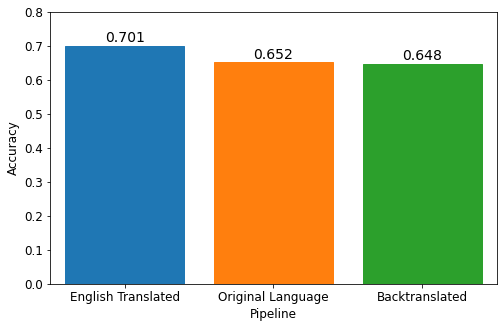

In [25]:
crete_sentiment_triple_barchart("NoNeuTweets", "figure1.png", 0.8)

### All Pipelines By Langauge, No Neutrals

Sentiment Analysis Task

Comparison of all three pipelines' accuracies for each language.

In [92]:
pipelines = ["Pipeline 2:\nTranslated to English\nw/o Neutrals", "Pipeline 1:\nCleaned Original Language\nw/o Neutrals", "Pipeline 3:\nTranslated Back to Original\nw/o Neutrals"]

In [93]:
def build_fig34_data(tweet_subset: str):
    """
    tweet_subset: Either "NoNeuTweets" or "AllTweets"
    """
    fig_data = { "Albanian" :   {},
                 "Arabic" :     {},
                 "Bosnian" :    {},
                 "Bulgarian" :  {},
                 "Chinese" :    {},
                 "Croatian" :   {},
                 "German" :     {},
                 "Hindi" :      {},
                 "Hungarian" :  {},
                 "Polish" :     {},
                 "Portuguese" : {},
                 "Russian" :    {},
                 "Slovak" :     {},
                 "Slovenian" :  {},
                 "Spanish" :    {},
                 "Swedish" :    {}  }


    for lang in fig_data:
        fig_data[lang]["Medians"] = [sent_data["Pipeline 2"][tweet_subset][lang]["Median"],
                                     sent_data["Pipeline 1"][tweet_subset][lang]["Median"],
                                     sent_data["Pipeline 3"][tweet_subset][lang]["Median"]]
        fig_data[lang]["99 Distances"] = [sent_data["Pipeline 2"][tweet_subset][lang]["99 Distance"],
                                          sent_data["Pipeline 1"][tweet_subset][lang]["99 Distance"],
                                          sent_data["Pipeline 3"][tweet_subset][lang]["99 Distance"]]

    fig_data["English"] = {
        "Medians": [0, sent_data["Pipeline 1"][tweet_subset]["English"]["Median"], 0],
        "99 Distances": [0, sent_data["Pipeline 1"][tweet_subset]["English"]["99 Distance"], 0]
    }
    
    return fig_data

In [94]:
def create_barchart(lang) -> None:
    bp = sns.barplot(x=pipelines, 
                     y=fig_data[lang]["Medians"],
                     yerr=fig_data[lang]["99 Distances"])

    for bar in bp.patches:
        bp.annotate(format(bar.get_height(), '.3f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=12, xytext=(0, 8),
                        textcoords='offset points')
    
    plt.rcParams["figure.figsize"] = (3,3)
    
    bp.patches[0].set_color("tab:blue")
    bp.patches[1].set_color("tab:orange")
    bp.patches[2].set_color("tab:green")
    
    # Hide x axis labels
    bp.set(xticklabels=[])
    
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(lang)

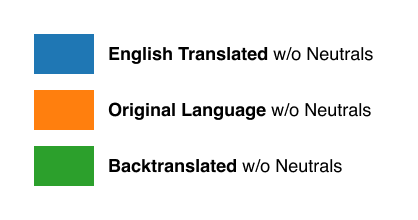

In [95]:
Image(filename="Figures/figure3-legend.png") 

In [96]:
fig_data = build_fig34_data("NoNeuTweets")

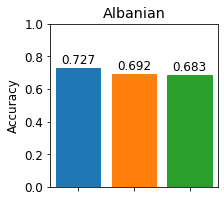

In [68]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Albanian")
plt.savefig("Figures/figure3-Albanian.png", bbox_inches="tight", dpi=2000)

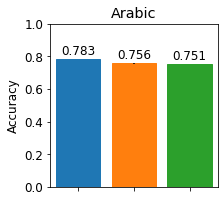

In [69]:
create_barchart("Arabic")
plt.savefig("Figures/figure3-Arabic.png", bbox_inches="tight", dpi=2000)

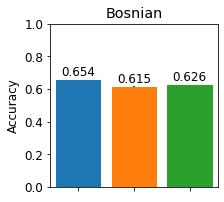

In [70]:
create_barchart("Bosnian")
plt.savefig("Figures/figure3-Bosnian.png", bbox_inches="tight", dpi=2000)

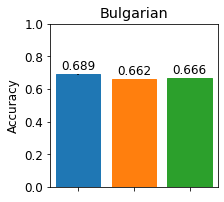

In [71]:
create_barchart("Bulgarian")
plt.savefig("Figures/figure3-Bulgarian.png", bbox_inches="tight", dpi=2000)

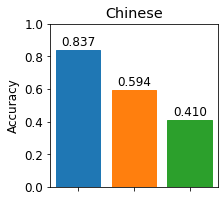

In [72]:
create_barchart("Chinese")
plt.savefig("Figures/figure3-Chinese.png", bbox_inches="tight", dpi=2000)

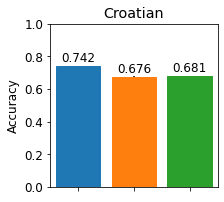

In [73]:
create_barchart("Croatian")
plt.savefig("Figures/figure3-Croation.png", bbox_inches="tight", dpi=2000)

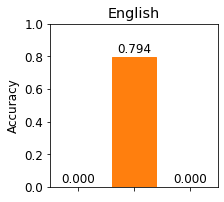

In [74]:
create_barchart("English")
plt.savefig("Figures/figure3-English.png", bbox_inches="tight", dpi=2000)

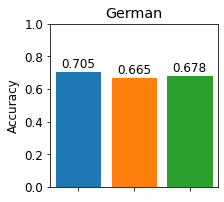

In [75]:
create_barchart("German")
plt.savefig("Figures/figure3-German.png", bbox_inches="tight", dpi=2000)

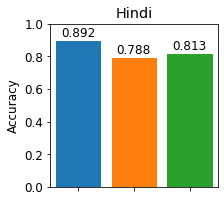

In [76]:
create_barchart("Hindi")
plt.savefig("Figures/figure3-Hindi.png", bbox_inches="tight", dpi=2000)

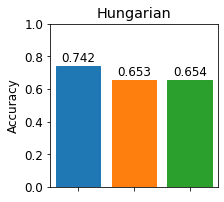

In [77]:
create_barchart("Hungarian")
plt.savefig("Figures/figure3-Hungarian.png", bbox_inches="tight", dpi=2000)

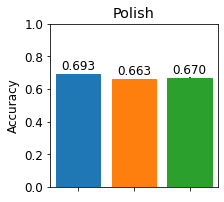

In [78]:
create_barchart("Polish")
plt.savefig("Figures/figure3-Polish.png", bbox_inches="tight", dpi=2000)

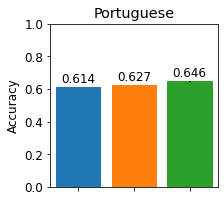

In [79]:
create_barchart("Portuguese")
plt.savefig("Figures/figure3-Portuguese.png", bbox_inches="tight", dpi=2000)

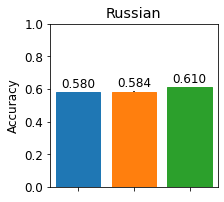

In [80]:
create_barchart("Russian")
plt.savefig("Figures/figure3-Russian.png", bbox_inches="tight", dpi=2000)

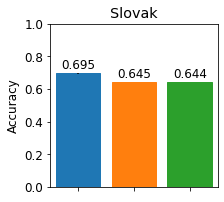

In [81]:
create_barchart("Slovak")
plt.savefig("Figures/figure3-Slovak.png", bbox_inches="tight", dpi=2000)

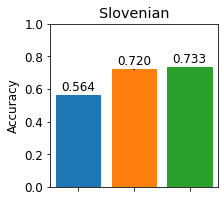

In [82]:
create_barchart("Slovenian")
plt.savefig("Figures/figure3-Slovenian.png", bbox_inches="tight", dpi=2000)

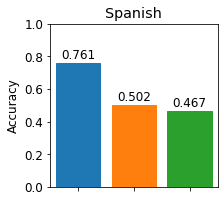

In [83]:
create_barchart("Spanish")
plt.savefig("Figures/figure3-Spanish.png", bbox_inches="tight", dpi=2000)

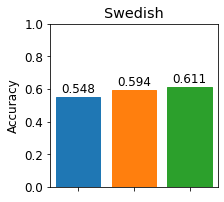

In [84]:
create_barchart("Swedish")
plt.savefig("Figures/figure3-Swedish.png", bbox_inches="tight", dpi=2000)

### All Pipelines Overall, With Neutrals

Sentiment Analysis Task

Comparison of all three pipelines' accuracies for each language, *with* neutrals.

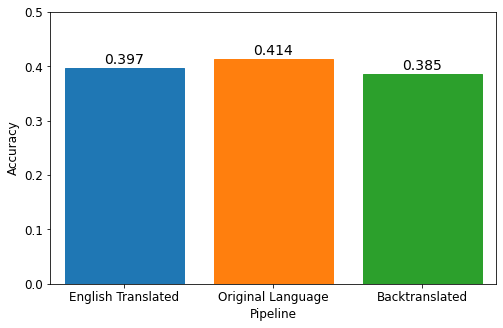

In [26]:
crete_sentiment_triple_barchart("AllTweets", "figure4.png", 0.5)

### All Pipelines By Langauge, With Neutrals

In [36]:
fig_data = build_fig34_data("AllTweets")

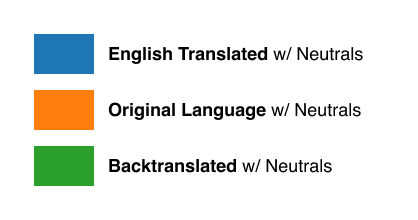

In [37]:
Image(filename="Figures/figure4-legend.png") 

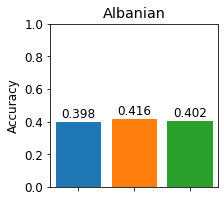

In [38]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Albanian")
plt.savefig("Figures/figure4-Albanian.png", bbox_inches="tight", dpi=2000)

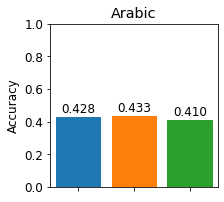

In [39]:
create_barchart("Arabic")
plt.savefig("Figures/figure4-Arabic.png", bbox_inches="tight", dpi=2000)

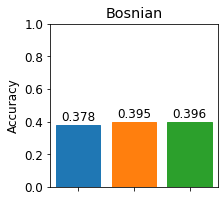

In [40]:
create_barchart("Bosnian")
plt.savefig("Figures/figure4-Bosnian.png", bbox_inches="tight", dpi=2000)

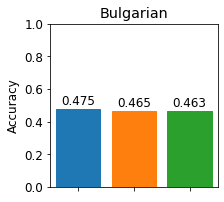

In [41]:
create_barchart("Bulgarian")
plt.savefig("Figures/figure4-Bulgarian.png", bbox_inches="tight", dpi=2000)

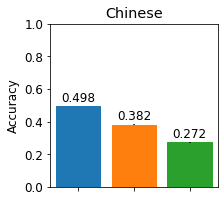

In [42]:
create_barchart("Chinese")
plt.savefig("Figures/figure4-Chinese.png", bbox_inches="tight", dpi=2000)

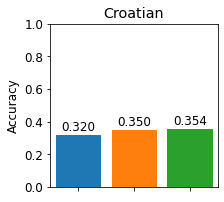

In [43]:
create_barchart("Croatian")
plt.savefig("Figures/figure4-Croatian.png", bbox_inches="tight", dpi=2000)

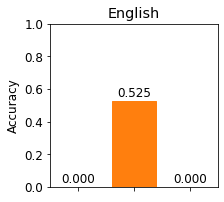

In [44]:
create_barchart("English")
plt.savefig("Figures/figure4-English.png", bbox_inches="tight", dpi=2000)

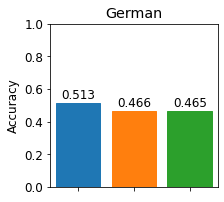

In [45]:
create_barchart("German")
plt.savefig("Figures/figure4-German.png", bbox_inches="tight", dpi=2000)

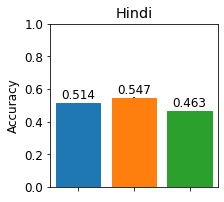

In [46]:
create_barchart("Hindi")
plt.savefig("Figures/figure4-Hindi.png", bbox_inches="tight", dpi=2000)

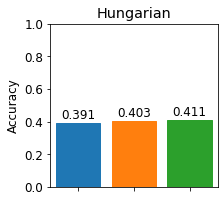

In [47]:
create_barchart("Hungarian")
plt.savefig("Figures/figure4-Hungarian.png", bbox_inches="tight", dpi=2000)

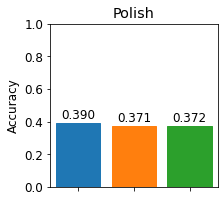

In [48]:
create_barchart("Polish")
plt.savefig("Figures/figure4-Polish.png", bbox_inches="tight", dpi=2000)

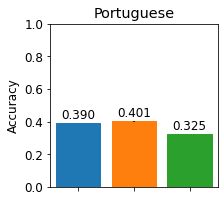

In [49]:
create_barchart("Portuguese")
plt.savefig("Figures/figure4-Portuguese.png", bbox_inches="tight", dpi=2000)

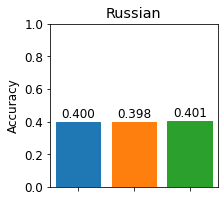

In [50]:
create_barchart("Russian")
plt.savefig("Figures/figure4-Russian.png", bbox_inches="tight", dpi=2000)

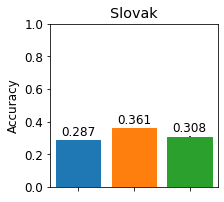

In [51]:
create_barchart("Slovak")
plt.savefig("Figures/figure4-Slovak.png", bbox_inches="tight", dpi=2000)

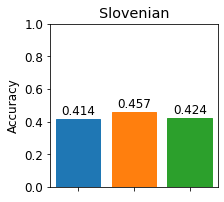

In [52]:
create_barchart("Slovenian")
plt.savefig("Figures/figure4-Slovenian.png", bbox_inches="tight", dpi=2000)

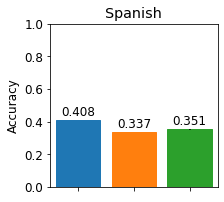

In [53]:
create_barchart("Spanish")
plt.savefig("Figures/figure4-Spanish.png", bbox_inches="tight", dpi=2000)

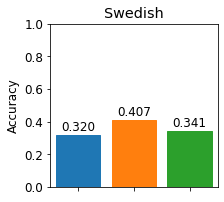

In [54]:
create_barchart("Swedish")
plt.savefig("Figures/figure4-Swedish.png", bbox_inches="tight", dpi=2000)

## Topic Clustering Task

### Topic Clustering Accuracy

Topic Clustering Task

No bootstrapping. Lines are the permutation test (chance) accuracy of each language.

Accuracy of Pipeline 3 compared to Pipeline 1.

In [56]:
def create_cluster_barchart(k : int):
    fig_data = copy.deepcopy(cluster_data[k])
    fig_data.pop("Average", None)
    fig_data.pop("Baseline", None)
    fig_data = pd.DataFrame({"Language": fig_data.keys(), 
                         "Accuracy": [fig_data[lang]["Accuracy"] for lang in fig_data],
                         "Perm Test": [fig_data[lang]["Perm Test"] for lang in fig_data]})

    plt.rcParams["figure.figsize"] = (15,5)

    fig, ax = plt.subplots()
    bp = sns.barplot(
        data=fig_data,
        x="Language",
        y="Accuracy",
        palette=sns.color_palette("tab10"),
        ax=ax)

    plt.ylim(0, 1)
    # bp.set_title("Figure 5")
    bp.set(xlabel="Language", ylabel="Accuracy")

    # Generate the horizontal chance lines on each bar
    for i in range(len(fig_data)):
        bp.axhline(fig_data["Perm Test"][i], 
                   xmin=i / len(fig_data) + 0.01, 
                   xmax=(i + 1) / len(fig_data) - 0.01, 
                   color="white")

    for i, bar in enumerate(bp.patches):
        # Annotate the bar height
        bp.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=12, xytext=(0, 8),
                    textcoords='offset points')
        # Annotate horizontal lines
        bp.annotate(format(fig_data["Perm Test"][i], '.3f'),
                    (i, fig_data["Perm Test"][i]), 
                    ha='center', va='center',
                    size=12, xytext=(0, 8),
                    textcoords='offset points',
                    color="white", weight=700)

    plt.savefig(f"Figures/figure5-{k}.png", bbox_inches="tight", dpi=2000)

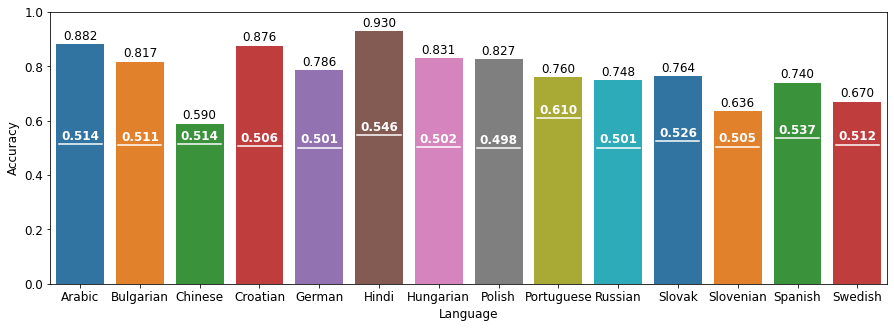

In [57]:
create_cluster_barchart(2)

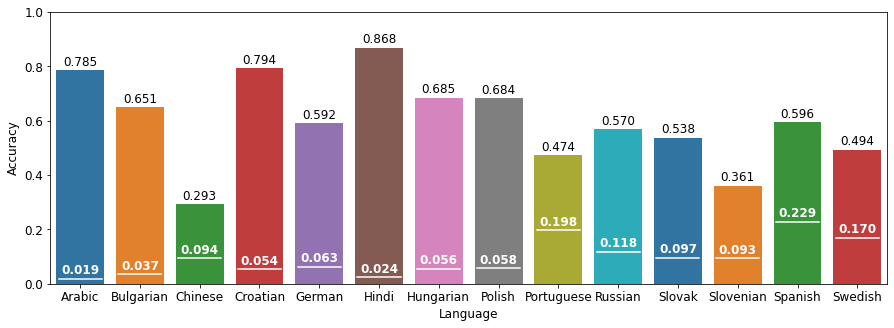

In [58]:
create_cluster_barchart(100)

### Effect of Clustering Size on Accuracy

Effect of k on topic clustering accuracy.

Average is the average of the accuracies of each langauge, not the overall accuracy of the datasets if they were combined.

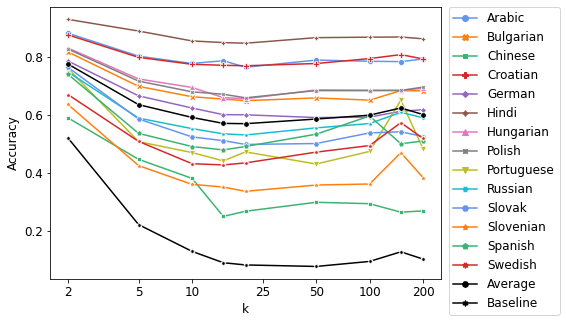

In [99]:
k_cluster_data = copy.deepcopy(cluster_data)

for k in k_cluster_data:
    for lang in k_cluster_data[k]:
        if lang == "Average" or lang == "Baseline":
            continue
        k_cluster_data[k][lang] = k_cluster_data[k][lang]["Accuracy"]

fig_data = pd.DataFrame(k_cluster_data).T
fig_data.index = fig_data.index.astype(int)
fig_data = fig_data.sort_index()

plt.rcParams["figure.figsize"] = (7,5)

palette = {'Arabic': "cornflowerblue",
  'Bulgarian': "tab:orange",
  'Chinese': "mediumseagreen",
  'Croatian': "tab:red",
  'German': "tab:purple",
  'Hindi': "tab:brown",
  'Hungarian': "tab:pink",
  'Polish': "tab:gray",
  'Portuguese': "tab:olive",
  'Russian': "tab:cyan",
  'Slovak': "cornflowerblue",
  'Slovenian': "tab:orange",
  'Spanish': "mediumseagreen",
  'Swedish': "tab:red",
  'Average': "black",
  'Baseline': "black"}

lp = sns.lineplot(
        data=fig_data,
        markers=True,
        dashes=False,
        palette=palette)

# lp.set_title("Figure 6")
lp.set(xlabel="k", ylabel="Accuracy")

plt.xscale('log')
ticks = [2, 5, 10, 25, 50, 100, 200]
lp.set_xticks(ticks)
lp.set_xticklabels(ticks)
lp.minorticks_off()

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.savefig("Figures/figure6.png", bbox_inches="tight", dpi=2000)

## Word Embeddings Task

### Word Embedding Distances

Word Embeddings Task Extension

Average distance between Pipeline 1 and Pipeline 3 sentence embeddings.

Two baseline distances given, used as a measure of sentence embedding distances to random sentences.

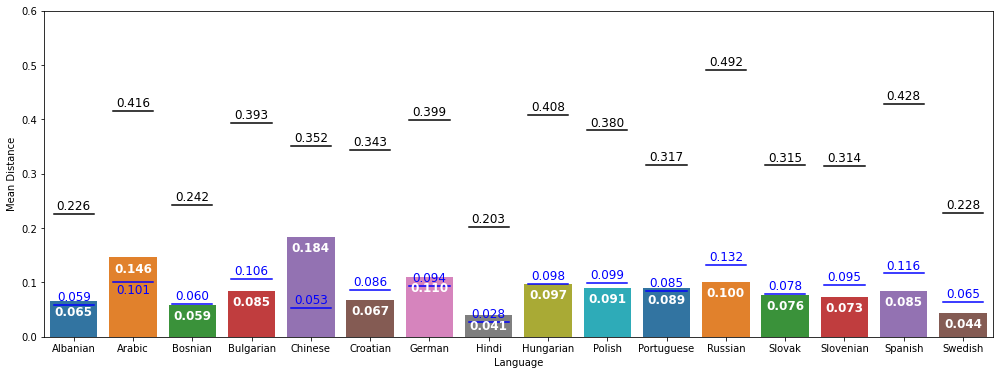

In [27]:
fig_data = pd.DataFrame({"Language": list(embeddings_data.keys()), 
                     "Mean Distance": [embeddings_data[lang]["Mean Distance"] for lang in embeddings_data],
                     "Baseline Mean": [embeddings_data[lang]["Baseline Mean"] for lang in embeddings_data],
                     "Baseline Min": [embeddings_data[lang]["Baseline Min"] for lang in embeddings_data]})

plt.rcParams["figure.figsize"] = (17,6)

fig, ax = plt.subplots()
bp = sns.barplot(
    data=fig_data,
    x="Language",
    y="Mean Distance",
    palette=sns.color_palette("tab10"),
    ax=ax)

plt.ylim(0, 0.6)
# bp.set_title("Figure 8")
bp.set(xlabel="Language", ylabel="Mean Distance")

# Generate the horizontal chance lines on each bar
for i in range(len(fig_data)):
    bp.axhline(fig_data["Baseline Mean"][i], 
               xmin=i / len(fig_data) + 0.01, 
               xmax=(i + 1) / len(fig_data) - 0.01, 
               color="black")
    bp.axhline(fig_data["Baseline Min"][i], 
               xmin=i / len(fig_data) + 0.01, 
               xmax=(i + 1) / len(fig_data) - 0.01, 
               color="blue")

for i, bar in enumerate(bp.patches):
    # Annotate the bar height
    bp.annotate(format(bar.get_height(), '.3f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.035), ha='center', va='center',
                size=12, xytext=(0, 8),
                textcoords='offset points',
                color="white", weight=700)
    
    # Annotate horizontal lines
    bp.annotate(format(fig_data["Baseline Mean"][i], '.3f'),
                (i, fig_data["Baseline Mean"][i]), 
                ha='center', va='center',
                size=12, xytext=(0, 8),
                textcoords='offset points',
                color="black", weight=500)

    # Annoatate below blue line where blue / white text collides
    yoffset = -8 if (i == 1) else 8
    bp.annotate(format(fig_data["Baseline Min"][i], '.3f'),
                (i, fig_data["Baseline Min"][i]), 
                ha='center', va='center',
                size=12, xytext=(0, yoffset),
                textcoords='offset points',
                color="blue", weight=500)
    
plt.savefig("Figures/figure8.png", bbox_inches="tight", dpi=2000)